In [12]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from tqdm import tqdm


In [13]:
# Input TOA and mask directories
toa_dir = r"D:\test\toa_tif_outputs"
cloud_mask_dir = r"C:\nrsc_test\cloud-masks\shadow_and_cloud_subset"

# Output directories for saved patches
output_image_dir = r"C:\nrsc_test\npy_patches_hahaha\images"
output_mask_dir = r"C:\nrsc_test\npy_patches_hahaha\masks"

# Patch size
patch_size = 128


In [14]:
# === Sun Elevation Angles (precomputed) ===
sun_elevation_lookup = {
    'BH_R2F27AUG2024069309009800054SSANSTUC00GTDA': 58.855629,
    'BH_R2F30APR2024067624010300067SSANSTUC00GTDB': 62.315206,
    'BH_RAF08MAY2024038491010700053SSANSTUC00GTDA': 70.708525,
    'BH_RAF10SEP2024040267010800054SSANSTUC00GTDC': 62.659743,
}


In [15]:


# === Scene IDs to Process ===
scene_ids = list(sun_elevation_lookup.keys())

# === Create output dirs ===
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)


In [16]:
patch_counter = 0

for scene_id in tqdm(scene_ids, desc="🔄 Processing scenes"):
    print(f"\n📂 Scene: {scene_id}")
    band_paths = {
        band: os.path.join(toa_dir, f"{scene_id}_{band}_toa.tif")
        for band in ["BAND2", "BAND3", "BAND4"]
    }
    cloud_path = os.path.join(cloud_mask_dir, f"cloud_{scene_id}.tif")
    shadow_path = os.path.join(cloud_mask_dir, f"shadow_{scene_id}.tif")
    sun_elev = sun_elevation_lookup[scene_id]

    missing = [p for p in list(band_paths.values()) + [cloud_path, shadow_path] if not os.path.exists(p)]
    if missing:
        print(f"[SKIP] Missing files for {scene_id}:")
        for m in missing:
            print(f"   ✘ {m}")
        continue
    with rasterio.open(band_paths["BAND2"]) as src:
        h, w = src.height, src.width

    total_patches = (h // patch_size + 1) * (w // patch_size + 1)
    with tqdm(total=total_patches, desc=f"🧩 Patches from {scene_id}", leave=False) as pbar:
        for y in range(0, h, patch_size):
            for x in range(0, w, patch_size):
                # === Load TOA bands ===
                bands = []
                empty_patch = True
                for band in ["BAND2", "BAND3", "BAND4"]:
                    with rasterio.open(band_paths[band]) as src:
                        window = Window(x, y, patch_size, patch_size)
                        patch = src.read(1, window=window, boundless=True, fill_value=0)
                        bands.append(patch)
                        if np.any(patch > 0):
                            empty_patch = False

                if empty_patch:
                    pbar.update(1)
                    continue

                image_patch = np.stack(bands, axis=0).astype(np.float32)

                # === Load cloud mask ===
                with rasterio.open(cloud_path) as src:
                    cloud_patch = src.read(1, window=Window(x, y, patch_size, patch_size), boundless=True, fill_value=0)

                # === Load shadow mask ===
                with rasterio.open(shadow_path) as src:
                    shadow_patch = src.read(1, window=Window(x, y, patch_size, patch_size), boundless=True, fill_value=0)

                # === Append cloud mask (channel 4) and sun angle layer (channel 5) ===
                cloud_patch = cloud_patch[np.newaxis, :, :].astype(np.float32)
                sun_patch = np.full((1, patch_size, patch_size), sun_elev / 90.0, dtype=np.float32)
                image_patch = np.concatenate([image_patch, cloud_patch, sun_patch], axis=0)

                # === Final mask: 0 = background, 2 = shadow ===
                mask_patch = np.zeros_like(shadow_patch, dtype=np.uint8)
                mask_patch[shadow_patch > 0] = 2

                # === Save ===
                np.save(os.path.join(output_image_dir, f"patch_{patch_counter:06d}_image.npy"), image_patch)
                np.save(os.path.join(output_mask_dir, f"patch_{patch_counter:06d}_mask.npy"), mask_patch)

                patch_counter += 1
                pbar.update(1)

print(f"\n✅ Saved {patch_counter} shadow training patches.")




🔄 Processing scenes:   0%|          | 0/4 [00:00<?, ?it/s]


📂 Scene: BH_R2F27AUG2024069309009800054SSANSTUC00GTDA


🔄 Processing scenes:  25%|██▌       | 1/4 [31:51<1:35:34, 1911.48s/it]


📂 Scene: BH_R2F30APR2024067624010300067SSANSTUC00GTDB


🔄 Processing scenes:  50%|█████     | 2/4 [54:47<53:13, 1596.73s/it]  


📂 Scene: BH_RAF08MAY2024038491010700053SSANSTUC00GTDA


🔄 Processing scenes:  75%|███████▌  | 3/4 [1:23:29<27:33, 1653.88s/it]


📂 Scene: BH_RAF10SEP2024040267010800054SSANSTUC00GTDC


🔄 Processing scenes: 100%|██████████| 4/4 [1:52:15<00:00, 1683.81s/it]


✅ Saved 57812 shadow training patches.


In [17]:
import os
import numpy as np

# === Paths ===
base_dir = r"C:\nrsc_test\npy_patches_hahaha"
image_dir = os.path.join(base_dir, "images")
mask_dir = os.path.join(base_dir, "masks")

# === File Lists ===
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".npy")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".npy")])

# === Basic Info ===
print(f"📁 Total image files: {len(image_files)}")
print(f"📁 Total mask files: {len(mask_files)}")
if len(image_files) != len(mask_files):
    print("⚠️ Mismatch in image and mask file counts!")

# === Load and inspect first file ===
if image_files and mask_files:
    image_path = os.path.join(image_dir, image_files[0])
    mask_path = os.path.join(mask_dir, mask_files[0])

    image = np.load(image_path)
    mask = np.load(mask_path)

    print(f"\n🖼️ First image file: {image_files[0]}")
    print(f" - Shape: {image.shape}")
    print(f" - Dtype: {image.dtype}")
    print(f" - Min: {np.min(image):.4f}, Max: {np.max(image):.4f}")

    print(f"\n🎭 First mask file: {mask_files[0]}")
    print(f" - Shape: {mask.shape}")
    print(f" - Dtype: {mask.dtype}")
    print(f" - Unique values: {np.unique(mask)}")

else:
    print("❌ No .npy files found in one or both folders.")


📁 Total image files: 57812
📁 Total mask files: 57812

🖼️ First image file: patch_000000_image.npy
 - Shape: (5, 128, 128)
 - Dtype: float32
 - Min: 0.0000, Max: 1.0000

🎭 First mask file: patch_000000_mask.npy
 - Shape: (128, 128)
 - Dtype: uint8
 - Unique values: [0]


In [18]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, random_split

# === Dataset ===
class NPYPatchDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".npy")])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".npy")])
        assert len(self.image_paths) == len(self.mask_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        mask[mask == 2] = 1  # Shadow = 1, Clear = 0
        if image.shape[0] != 5:
            image = image.transpose(2, 0, 1)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

# === Stats Function ===
def compute_shadow_stats(dataset, label=1):
    total_pixels = 0
    shadow_pixels = 0
    for _, mask in dataset:
        shadow_pixels += torch.sum(mask == label).item()
        total_pixels += mask.numel()
    pct = (shadow_pixels / total_pixels) * 100 if total_pixels > 0 else 0
    return total_pixels, shadow_pixels, pct

# === Paths ===
image_dir = r"C:\nrsc_test\npy_patches_hahaha\images"
mask_dir = r"C:\nrsc_test\npy_patches_hahaha\masks"

# === Load dataset ===
dataset = NPYPatchDataset(image_dir, mask_dir)
print(f"✅ Total image-mask pairs: {len(dataset)}")

# === Split ratios ===
train_ratio, val_ratio = 0.7, 0.15
test_ratio = 1 - train_ratio - val_ratio

train_len = int(train_ratio * len(dataset))
val_len = int(val_ratio * len(dataset))
test_len = len(dataset) - train_len - val_len

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len],
                                            generator=torch.Generator().manual_seed(42))

# === Stats per split ===
for name, subset in zip(["Train", "Val", "Test"], [train_set, val_set, test_set]):
    total, shadow, pct = compute_shadow_stats(subset)
    print(f"\n📂 {name} Set")
    print(f" - Samples       : {len(subset)}")
    print(f" - Total Pixels  : {total:,}")
    print(f" - Shadow Pixels : {shadow:,}")
    print(f" - Shadow Coverage: {pct:.2f}%")


✅ Total image-mask pairs: 57812

📂 Train Set
 - Samples       : 40468
 - Total Pixels  : 663,027,712
 - Shadow Pixels : 20,518,086
 - Shadow Coverage: 3.09%

📂 Val Set
 - Samples       : 8671
 - Total Pixels  : 142,065,664
 - Shadow Pixels : 4,196,026
 - Shadow Coverage: 2.95%

📂 Test Set
 - Samples       : 8673
 - Total Pixels  : 142,098,432
 - Shadow Pixels : 4,573,046
 - Shadow Coverage: 3.22%


In [21]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=5, n_classes=2, dropout=0.2):
        super().__init__()
        self.down1 = DoubleConv(n_channels, 64, dropout)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128, dropout)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256, dropout)
        self.pool3 = nn.MaxPool2d(2)
        self.middle = DoubleConv(256, 512, dropout)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256, dropout)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128, dropout)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64, dropout)
        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        mid = self.middle(self.pool3(d3))
        u3 = self.up3(mid)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)
        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)
        return self.out(u1)


In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=16, shuffle=False)


In [23]:
import torch

# Pixel counts from your dataset
clear_pixels = 917_904_650
shadow_pixels = 29_287_158
total_pixels = clear_pixels + shadow_pixels

# Raw inverse frequency
w_clear = total_pixels / clear_pixels
w_shadow = total_pixels / shadow_pixels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize weights (optional but recommended)
norm_factor = (w_clear + w_shadow)
weights = torch.tensor([w_clear / norm_factor, w_shadow / norm_factor], dtype=torch.float32).to(device)

print("📊 Class Weights for CrossEntropyLoss:")
print(f" - Clear  (0): {weights[0].item():.4f}")
print(f" - Shadow (1): {weights[1].item():.4f}")

# Use in loss function
criterion = nn.CrossEntropyLoss(weight=weights)


📊 Class Weights for CrossEntropyLoss:
 - Clear  (0): 0.0309
 - Shadow (1): 0.9691


In [24]:
import torch.optim as optim
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = UNet(n_channels=5, n_classes=2, dropout=0.2).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Weighted CrossEntropyLoss
# From your stats:
# Class 0 (Clear): 0.0309
# Class 1 (Shadow): 0.9691
weights = torch.tensor([0.0309, 0.9691], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


In [25]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10, save_dir="models_weighted_dropout"):
    os.makedirs(save_dir, exist_ok=True)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        print(f"\n🚀 Epoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc="🔧 Training"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="🧪 Validation"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"📉 Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Save model
        model_path = os.path.join(save_dir, f"shadow_unet_dropout_wce_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"💾 Saved: {model_path}")

    # === Plot losses ===
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves (Dropout + Weighted Loss)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



🚀 Epoch 1/10


🧪 Validation: 100%|██████████| 542/542 [03:46<00:00,  2.40it/s]


📉 Train Loss: 0.2964 | Val Loss: 0.1635
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch1.pth

🚀 Epoch 2/10


🧪 Validation: 100%|██████████| 542/542 [03:49<00:00,  2.36it/s]


📉 Train Loss: 0.2165 | Val Loss: 0.2301
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch2.pth

🚀 Epoch 3/10


🧪 Validation: 100%|██████████| 542/542 [03:33<00:00,  2.54it/s]


📉 Train Loss: 0.1979 | Val Loss: 0.1197
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch3.pth

🚀 Epoch 4/10


🧪 Validation: 100%|██████████| 542/542 [03:53<00:00,  2.32it/s]


📉 Train Loss: 0.1853 | Val Loss: 0.1050
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch4.pth

🚀 Epoch 5/10


🧪 Validation: 100%|██████████| 542/542 [03:41<00:00,  2.45it/s]


📉 Train Loss: 0.1694 | Val Loss: 0.1090
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch5.pth

🚀 Epoch 6/10


🧪 Validation: 100%|██████████| 542/542 [03:18<00:00,  2.73it/s]


📉 Train Loss: 0.1620 | Val Loss: 0.0915
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch6.pth

🚀 Epoch 7/10


🧪 Validation: 100%|██████████| 542/542 [03:20<00:00,  2.71it/s]


📉 Train Loss: 0.1489 | Val Loss: 0.0855
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch7.pth

🚀 Epoch 8/10


🧪 Validation: 100%|██████████| 542/542 [03:27<00:00,  2.61it/s]


📉 Train Loss: 0.1465 | Val Loss: 0.1081
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch8.pth

🚀 Epoch 9/10


🧪 Validation: 100%|██████████| 542/542 [03:17<00:00,  2.74it/s]


📉 Train Loss: 0.1455 | Val Loss: 0.0788
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch9.pth

🚀 Epoch 10/10


🧪 Validation: 100%|██████████| 542/542 [03:19<00:00,  2.71it/s]


📉 Train Loss: 0.1379 | Val Loss: 0.0755
💾 Saved: models_weighted_dropout\shadow_unet_dropout_wce_epoch10.pth


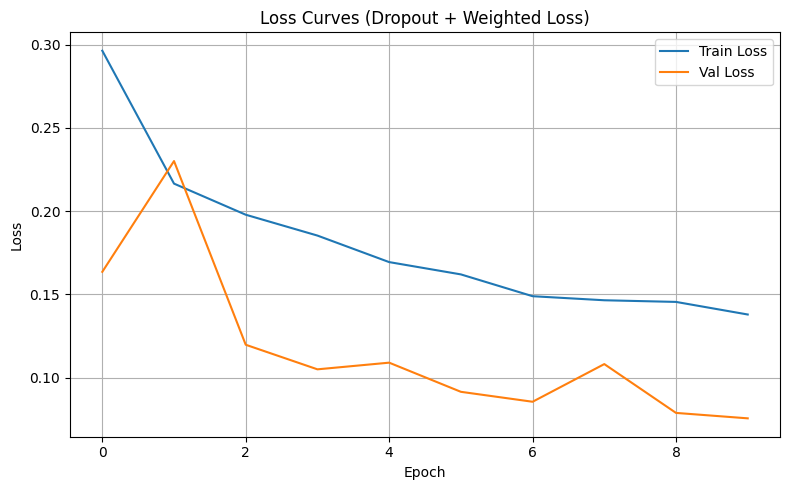

In [26]:
train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10)


C:\Users\devka\AppData\Local\Temp\ipykernel_8484\3083333954.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


🔍 Evaluating Epoch 5 | C:\nrsc_test\models_weighted_dropout\shadow_unet_dropout_wce_epoch5.pth


Epoch 5: 100%|██████████| 543/543 [04:25<00:00,  2.05it/s]



📊 Classification Report:
              precision    recall  f1-score   support

       Clear       1.00      0.93      0.97 137525386
      Shadow       0.33      0.99      0.50   4573046

    accuracy                           0.94 142098432
   macro avg       0.67      0.96      0.73 142098432
weighted avg       0.98      0.94      0.95 142098432



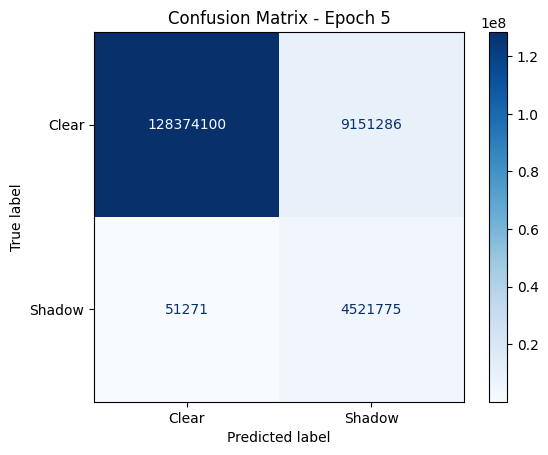


🔍 Evaluating Epoch 6 | C:\nrsc_test\models_weighted_dropout\shadow_unet_dropout_wce_epoch6.pth


C:\Users\devka\AppData\Local\Temp\ipykernel_8484\3083333954.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


📊 Classification Report:
              precision    recall  f1-score   support

       Clear       1.00      0.96      0.98 137525386
      Shadow       0.44      0.98      0.61   4573046

    accuracy                           0.96 142098432
   macro avg       0.72      0.97      0.79 142098432
weighted avg       0.98      0.96      0.97 142098432



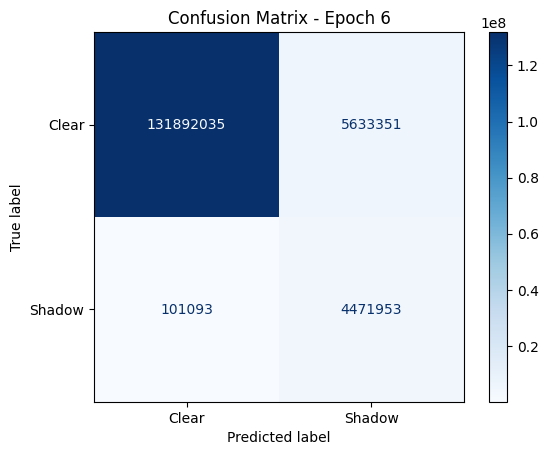


🔍 Evaluating Epoch 7 | C:\nrsc_test\models_weighted_dropout\shadow_unet_dropout_wce_epoch7.pth


C:\Users\devka\AppData\Local\Temp\ipykernel_8484\3083333954.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


📊 Classification Report:
              precision    recall  f1-score   support

       Clear       1.00      0.96      0.98 137525386
      Shadow       0.44      0.99      0.61   4573046

    accuracy                           0.96 142098432
   macro avg       0.72      0.97      0.79 142098432
weighted avg       0.98      0.96      0.97 142098432



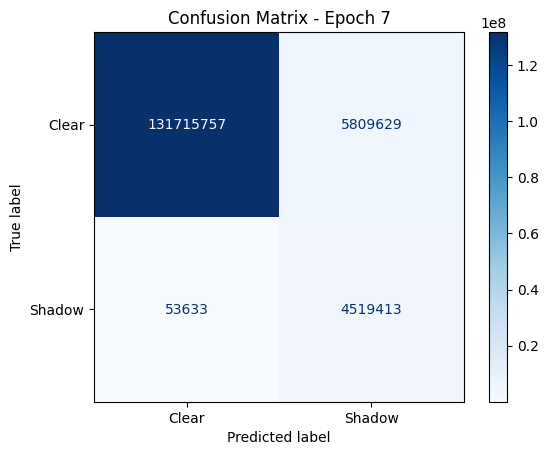


🔍 Evaluating Epoch 8 | C:\nrsc_test\models_weighted_dropout\shadow_unet_dropout_wce_epoch8.pth


C:\Users\devka\AppData\Local\Temp\ipykernel_8484\3083333954.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


📊 Classification Report:
              precision    recall  f1-score   support

       Clear       1.00      0.93      0.96 137525386
      Shadow       0.32      0.99      0.49   4573046

    accuracy                           0.93 142098432
   macro avg       0.66      0.96      0.73 142098432
weighted avg       0.98      0.93      0.95 142098432



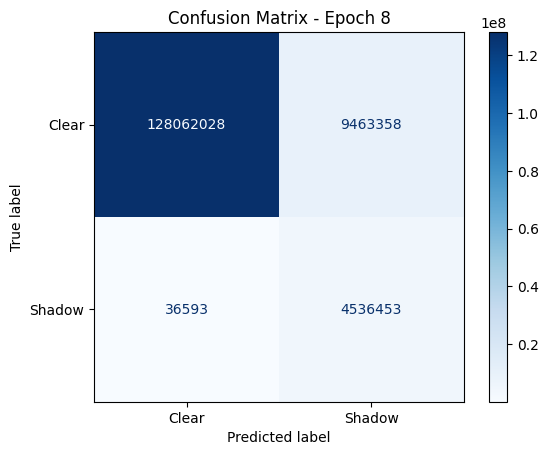


🔍 Evaluating Epoch 9 | C:\nrsc_test\models_weighted_dropout\shadow_unet_dropout_wce_epoch9.pth


C:\Users\devka\AppData\Local\Temp\ipykernel_8484\3083333954.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


📊 Classification Report:
              precision    recall  f1-score   support

       Clear       1.00      0.96      0.98 137525386
      Shadow       0.45      0.99      0.62   4573046

    accuracy                           0.96 142098432
   macro avg       0.72      0.97      0.80 142098432
weighted avg       0.98      0.96      0.97 142098432



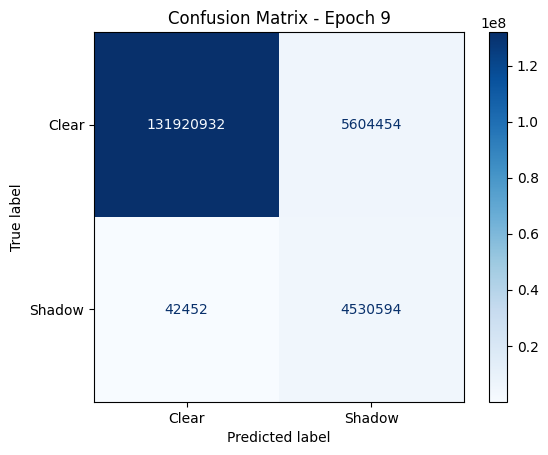


🔍 Evaluating Epoch 10 | C:\nrsc_test\models_weighted_dropout\shadow_unet_dropout_wce_epoch10.pth


C:\Users\devka\AppData\Local\Temp\ipykernel_8484\3083333954.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


📊 Classification Report:
              precision    recall  f1-score   support

       Clear       1.00      0.96      0.98 137525386
      Shadow       0.43      0.99      0.60   4573046

    accuracy                           0.96 142098432
   macro avg       0.72      0.97      0.79 142098432
weighted avg       0.98      0.96      0.97 142098432



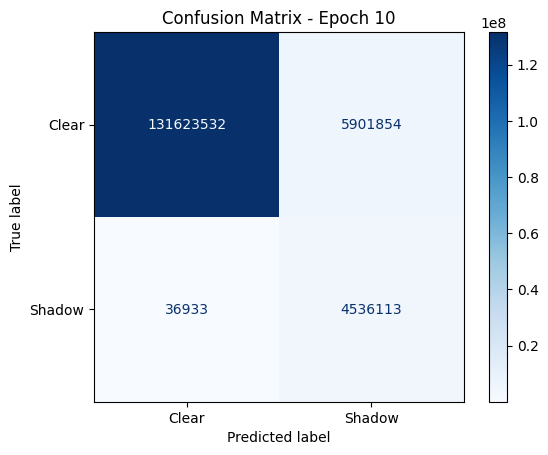

In [28]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm



# === Paths ===

model_dir = r"C:\nrsc_test\models_weighted_dropout"


# === Evaluate models ===
for epoch in range(5, 11):
    model_path = os.path.join(model_dir, f"shadow_unet_dropout_wce_epoch{epoch}.pth")
    print(f"\n🔍 Evaluating Epoch {epoch} | {model_path}")
    
    model = UNet(n_channels=5, n_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Epoch {epoch}"):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds.flatten())
            y_true.extend(masks.numpy().flatten())

    # === Classification Report ===
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Clear", "Shadow"]))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clear", "Shadow"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.grid(False)
    plt.show()


In [33]:
import os
import numpy as np

# === Path to the mask folder ===
mask_dir = r"C:\nrsc_test\npy_patches_hahaha\masks"

# === Threshold ===
shadow_threshold = 10

# === Loop through .npy files ===
for fname in sorted(os.listdir(mask_dir)):
    if fname.endswith(".npy"):
        fpath = os.path.join(mask_dir, fname)
        mask = np.load(fpath)
        
        shadow_pixels = np.sum(mask == 2)
        
        if shadow_pixels > shadow_threshold:
            print(f"✅ Found: {fname} → {shadow_pixels} shadow pixels")
            break


✅ Found: patch_000030_mask.npy → 679 shadow pixels


C:\Users\devka\AppData\Local\Temp\ipykernel_8484\1479149970.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

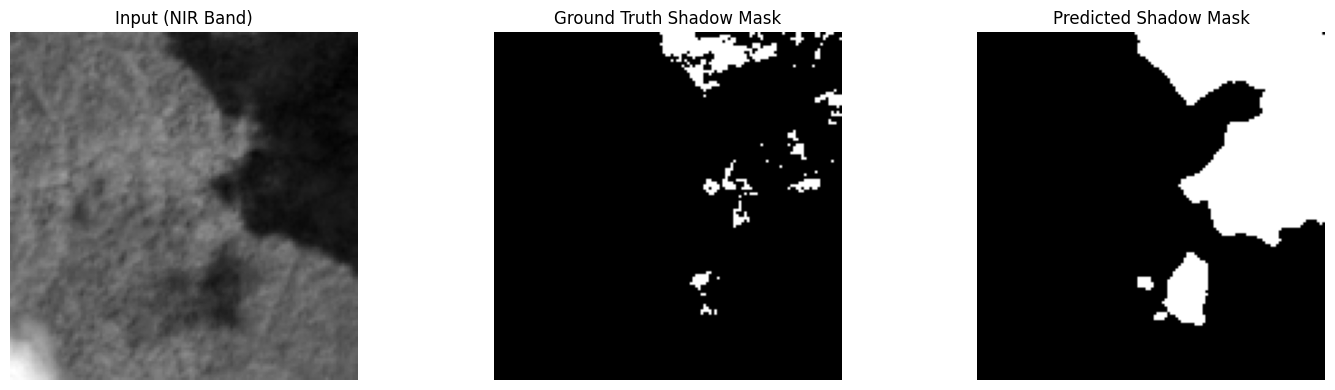

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# === Paths ===
model_path = r"C:\nrsc_test\models_weighted_dropout\shadow_unet_dropout_wce_epoch9.pth"
image_path = r"C:\nrsc_test\npy_patches_hahaha\images\patch_000030_image.npy"
mask_path  = r"C:\nrsc_test\npy_patches_hahaha\masks\patch_000030_mask.npy"

# === Load image and ground truth mask ===
image = np.load(image_path)  # shape: (5, 128, 128)
mask = np.load(mask_path)    # shape: (128, 128)

assert image.shape[0] == 5, "Input image must have 5 channels"
input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

# === Load model ===
model = UNet(n_channels=5, n_classes=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === Predict ===
with torch.no_grad():
    output = model(input_tensor)
    pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# === Plot Input, Ground Truth, and Prediction ===
plt.figure(figsize=(15, 4))

# Input NIR
plt.subplot(1, 3, 1)
plt.imshow(image[2], cmap='gray')
plt.title("Input (NIR Band)")
plt.axis("off")

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Shadow Mask")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Shadow Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# === Optionally Save ===
np.save("predicted_shadow_mask.npy", pred_mask)
